In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from poker_utils.model import prob_embeddings, analyze_embeddings, evaluate_hand_hand_equity, save_model_and_embeddings


In [2]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")
equity_matrix = pd.read_csv("data/processed/equity_matrix.csv")


In [3]:
full_data = pd.concat(
    [base_data, 
     blocker_data, 
     equity_data, 
     ev_data], axis=1)

In [4]:
cols = [
    'suited', 'connectedness', 'pair', 'high_card', 'low_card',
    'rank_diff', 'ace', 'broadway', 'low_pair', 'medium_pair',
    'high_pair', 'broadway_score', 'suited_broadway',
    'suited_broadway_score', 'connector', 'one_gap', 'two_gap',
    'suited_connector', 'suited_one_gap', 'suited_two_gap',
    'connectedness_score', 'rank_diff_score', 'high_card_score',
    'low_card_score', 'suited_connected_score',
       
    'block_aa', 'block_kk', 'block_qq', 'block_ak', 'block_aq',
    'prem_blocker_score', 'prem_blocker_score_norm', 'block_aa_score',
    'block_kk_score',
       
    'tot_win_perc', 'high_card_win_perc',
    'one_pair_win_perc', 'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential',
       
    'BB_play10', 'BB_play2', 'BB_play3', 'BB_play4', 'BB_play5', 'BB_play6',
    'BB_play7', 'BB_play8', 'BB_play9', 'D_play10', 'D_play3', 'D_play4',
    'D_play5', 'D_play6', 'D_play7', 'D_play8', 'D_play9', 'SB_play10',
    'SB_play2', 'SB_play3', 'SB_play4', 'SB_play5', 'SB_play6', 'SB_play7',
    'SB_play8', 'SB_play9', 'pos3_play10', 'pos3_play4', 'pos3_play5',
    'pos3_play6', 'pos3_play7', 'pos3_play8', 'pos3_play9', 'pos4_play10',
    'pos4_play5', 'pos4_play6', 'pos4_play7', 'pos4_play8', 'pos4_play9',
    'pos5_play10', 'pos5_play6', 'pos5_play7', 'pos5_play8', 'pos5_play9',
    'pos6_play10', 'pos6_play7', 'pos6_play8', 'pos6_play9', 'pos7_play10',
    'pos7_play8', 'pos7_play9', 'pos8_play10', 'pos8_play9', 'pos9_play10'
]

In [5]:
scaler = StandardScaler()

In [6]:
X = np.concat([full_data[cols].to_numpy(), equity_matrix.set_index("hand").to_numpy()],axis=1)
X_scaled = scaler.fit_transform(X)

In [7]:
pca = PCA(n_components=16)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_pca_norm = normalize(X_pca, norm='l2')

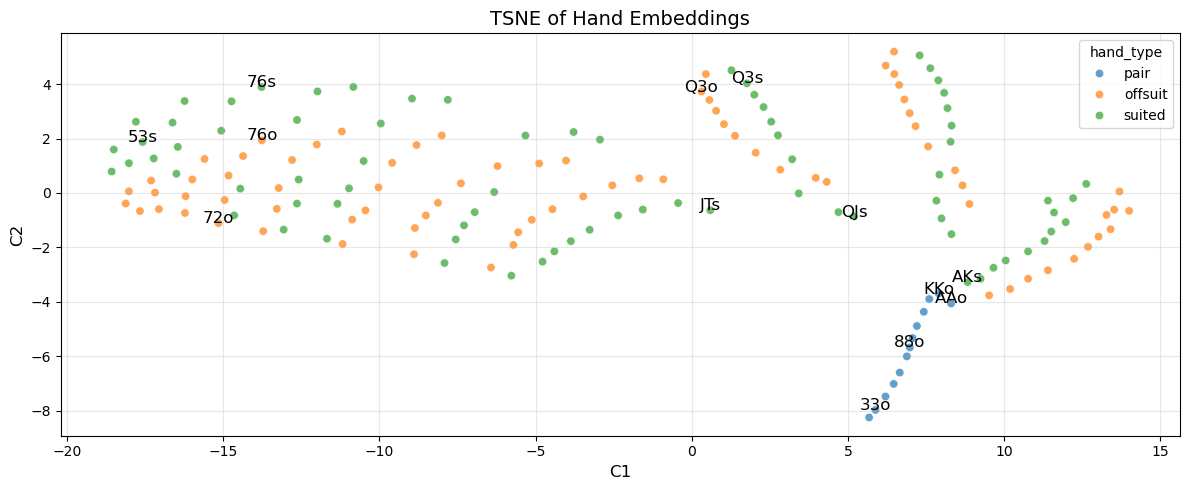

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.9791)  QQo (0.9485)  JJo (0.8964)  92s (-0.5999)   
1   KKo  AAo (0.9791)  QQo (0.9727)  JJo (0.9364)  92s (-0.6658)   
2   72o  73o (0.9745)  62o (0.9731)  82o (0.9703)  99o (-0.7642)   
3   76s  65s (0.9016)  87s (0.8532)  76o (0.8327)  K8o (-0.6096)   
4   76o  75o (0.9531)  85o (0.9126)  65o (0.9111)  A9s (-0.7417)   
5   Q3s  Q4s (0.9220)  Q3o (0.8618)  Q5s (0.8217)  KKo (-0.3095)   
6   Q3o  Q4o (0.9291)  Q3s (0.8618)  Q5o (0.8406)  KKo (-0.4719)   
7   88o  99o (0.9800)  77o (0.9772)  TTo (0.9213)  52o (-0.7551)   
8   JTs  QJs (0.8138)  T9s (0.8042)  J9s (0.7806)  84o (-0.7064)   
9   33o  44o (0.9303)  22o (0.9160)  55o (0.7865)  J6o (-0.3227)   
10  AKs  AKo (0.9623)  AQs (0.9394)  AJs (0.9016)  T5o (-0.7112)   
11  53s  42s (0.9792)  64s (0.9636)  53o (0.9247)  88o (-0.6689)   
12  QJs  QTs (0.8844)  KQs (0.8477)  QJo (0.8170)  93o (-0.8016)   

         bottom_2       bottom_3  
0   83s (-0.

In [8]:
similarity_df = analyze_embeddings(
    X_pca_norm, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s","QJs"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

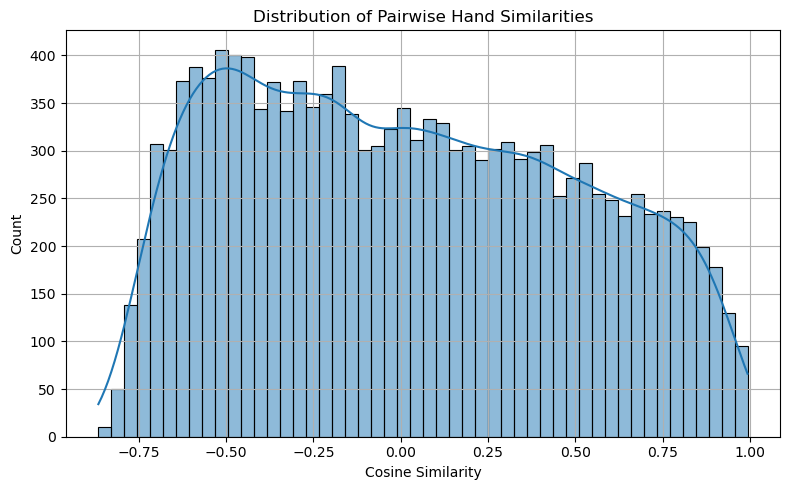

In [9]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)
all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
equity_matrix = equity_matrix.set_index('hand').to_numpy()

In [11]:
evaluate_hand_hand_equity(X_pca_norm, equity_matrix)


{'spear_corr': np.float64(0.7051361881066612), 'pval': np.float64(0.0)}

In [12]:
prob_data = pd.read_csv('data/processed/prob_data.csv')

In [13]:
prob_res = prob_embeddings(X_pca_norm, prob_data)

In [14]:
prob_res.sort_values(by='accuracy')

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
23,high_card,7,0.95858,0.933333,0.933333,0.933333,0.088757,NaN
22,high_card,6,0.95858,1.000000,0.923077,0.960000,0.076923,NaN
21,high_card,5,0.95858,1.000000,1.000000,1.000000,0.065089,NaN
28,high_card,12,0.95858,1.000000,1.000000,1.000000,0.147929,NaN
27,high_card,11,0.95858,1.000000,1.000000,1.000000,0.136095,NaN
...,...,...,...,...,...,...,...,...
59,pos7_play8,NaN,NaN,NaN,NaN,NaN,NaN,0.132155
60,pos7_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.134439
61,pos8_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.138403
62,pos8_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.141531


In [ ]:
# save_model_and_embeddings(
#     X_pca_norm,
#     "preflop_pca_embedding"
# )

In [ ]:
# prob_res.to_csv("results/prob_preflop_pca16.csv", index=False)
# similarity_df.reset_index().rename({"index":'hand'},axis=1).to_csv("results/sim_preflop_pca16.csv")